In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
from category_encoders import CatBoostEncoder
from sklearn.preprocessing import MinMaxScaler
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from bayes_opt import BayesianOptimization
import math
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from hyperopt import hp, fmin, tpe, Trials
import shap
from catboost.utils import get_roc_curve
from catboost import Pool

C:\Users\master\anaconda3\envs\EDA\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
org_data_train = pd.read_csv('autoam-car-price-prediction/train.csv')
org_data_test = pd.read_csv('autoam-car-price-prediction/test.csv')
save_data_train = deepcopy(org_data_train)
save_data_test = deepcopy(org_data_test)

In [3]:
org_data_train.head()

,model,year,motor_type,running,wheel,color,type,status,motor_volume,price
0,toyota,2022,petrol,3000 km,left,skyblue,sedan,excellent,2.0,24500
1,mercedes-benz,2014,petrol,132000 km,left,black,sedan,excellent,2.0,25500
2,kia,2018,petrol,95000 miles,left,other,sedan,excellent,2.0,11700
3,mercedes-benz,2002,petrol,137000 miles,left,golden,sedan,excellent,3.2,12000
4,mercedes-benz,2017,petrol,130000 km,left,black,sedan,good,2.0,26000


In [4]:
def km_mile_convert(value):
    if 'km' in value:
        return float(value.replace(' km', ''))  # km를 miles로 변환
    elif 'miles' in value:
        return round(float(value.replace(' miles', '')) * 1.60934, 2) # 그대로 반환
    
org_data_train['running'] = org_data_train['running'].apply(km_mile_convert)
org_data_test['running'] = org_data_test['running'].apply(km_mile_convert)

In [5]:
# wheel 데이터는 전부 left여서 컬럼자체를 드랍
org_data_train.drop('wheel', axis=1, inplace=True)

# 상관관계 분석결과 motor_volume은 관계성이 0에 가까우므로 우선 드랍
org_data_train.drop('motor_volume', axis=1, inplace=True)


# test에 적용
org_data_test.drop('wheel', axis=1, inplace=True)
org_data_test.drop('motor_volume', axis=1, inplace=True)

In [6]:
# moter_type 원핫 인코딩, 범주가 5개이며, 데이터가 불균형하여 해당 인코딩 선택
one_hot_motor_type = deepcopy(org_data_train['motor_type'])
one_hot_motor_type = pd.get_dummies(one_hot_motor_type, dtype = int)
org_data_train.drop('motor_type', axis=1, inplace=True)
org_data_train = pd.concat([org_data_train, one_hot_motor_type], axis=1)

# test에 적용
one_hot_motor_type = deepcopy(org_data_test['motor_type'])
one_hot_motor_type = pd.get_dummies(one_hot_motor_type, dtype = int)
org_data_test.drop('motor_type', axis=1, inplace=True)
org_data_test = pd.concat([org_data_test, one_hot_motor_type], axis=1)

# 전체 원핫 인코딩, 범주가 5개이며, 데이터가 불균형하여 해당 인코딩 선택
one_hot_motor_type = deepcopy(org_data_train[['type', 'model', 'color', 'status']])
one_hot_motor_type = pd.get_dummies(one_hot_motor_type, dtype = int)

one_hot_org_data = deepcopy(org_data_train).drop(['type', 'model', 'color', 'status'], axis=1)
one_hot_org_data = pd.concat([one_hot_org_data, one_hot_motor_type], axis=1)
#org_data_train.drop('motor_type', axis=1, inplace=True)
#org_data_train = pd.concat([org_data_train, one_hot_motor_type], axis=1)


#test하고 train셋에서 motor type확인해보면 test에서 diesel과 hybrid가 없음, 컬럼제거함
one_hot_org_data = one_hot_org_data.drop(columns=['diesel', 'hybrid'])
del_000_list = one_hot_org_data[(one_hot_org_data['gas'] == 0) & (one_hot_org_data['petrol'] == 0) & (one_hot_org_data['petrol and gas'] == 0)].index
one_hot_org_data = one_hot_org_data.drop(del_000_list)


In [11]:
#전체데이터 다넣어서 해봄

def catboost_cv_total(learning_rate, depth, l2_leaf_reg):
    # CatBoost 모델 정의
    model = CatBoostRegressor(
        iterations = 1000,
        learning_rate = learning_rate,
        depth = int(depth),
        l2_leaf_reg = l2_leaf_reg,
        verbose = 0
    )
    
    # 모델 학습
    model.fit(X_train, y_train)
    
    # 검증 데이터에 대한 예측
    y_pred = model.predict(X_test)
    
    # mae 에러
    mae = mean_absolute_error(y_test, y_pred)
    
    # 최소화할 목적 함수 반환
    return -mae


total_train = deepcopy(org_data_train)

x = one_hot_org_data.drop('price', axis = 1)
y = one_hot_org_data['price']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

#베이지안 최적화
optimizer = BayesianOptimization(
f = catboost_cv_total,
pbounds = pbounds,
random_state = 42,
)

optimizer.maximize(init_points = 5, n_iter = 10)
print(optimizer.max)

    

|   iter    |  target   |   depth   | l2_lea... | learni... |
-------------------------------------------------------------
| 1         | -2.144e+0 | 5.622     | 9.556     | 0.2223    |
| 2         | -2.067e+0 | 7.191     | 2.404     | 0.05524   |
| 3         | -2.063e+0 | 3.407     | 8.796     | 0.1843    |
| 4         | -2.298e+0 | 7.957     | 1.185     | 0.2913    |
| 5         | -2.107e+0 | 8.827     | 2.911     | 0.06273   |
| 6         | -2.162e+0 | 7.217     | 2.467     | 0.07781   |
| 7         | -1.971e+0 | 4.125     | 4.591     | 0.03509   |
| 8         | -1.993e+0 | 5.277     | 5.312     | 0.05141   |
| 9         | -2.108e+0 | 9.601     | 4.311     | 0.07418   |
| 10        | -2.122e+0 | 9.259     | 8.754     | 0.1298    |
| 11        | -2.298e+0 | 5.326     | 7.119     | 0.2893    |
| 12        | -2.057e+0 | 3.661     | 8.211     | 0.1828    |
| 13        | -2.202e+0 | 5.821     | 8.566     | 0.2297    |
| 14        | -2.334e+0 | 7.272     | 2.993     | 0.2931    |
| 15    

In [13]:
# 전체 데이터 모델 학습
'''
model = CatBoostRegressor(iterations = 1000, 
                              learning_rate = 0.035, 
                              depth = 4, 
                              l2_leaf_reg = 4.591, 
                              verbose = 0)
'''
model = CatBoostRegressor(iterations = 1000, 
                              learning_rate = optimizer.max['params']['learning_rate'], 
                              depth = int(round(optimizer.max['params']['depth'], 0)), 
                              l2_leaf_reg = optimizer.max['params']['l2_leaf_reg'], 
                              verbose = 0)

model.fit(X_train, y_train)

# 모델 평가
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print()
print(f"Mean Absolute Error (MAE): {mae}")
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')
print()


Mean Absolute Error (MAE): 1970.9121647925
Mean Squared Error: 10946054.092433734
R^2 Score: 0.7727782634349104



summary plot


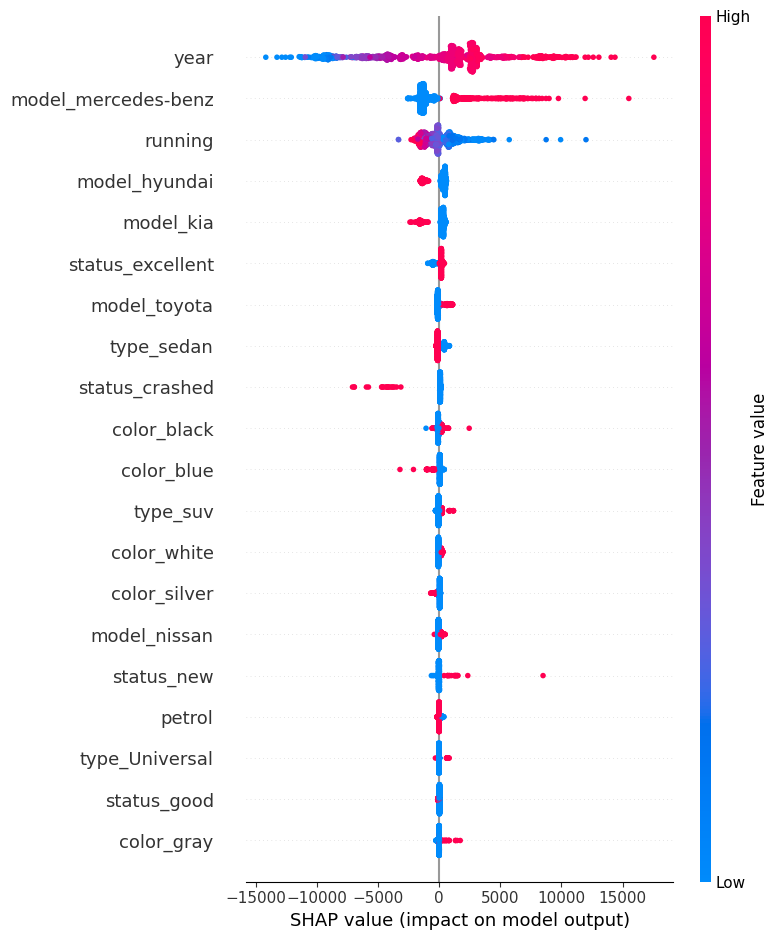

dependence plot


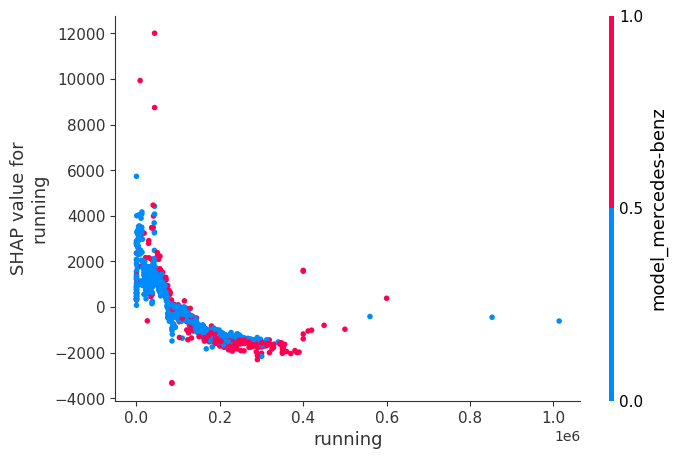

waterfall plot


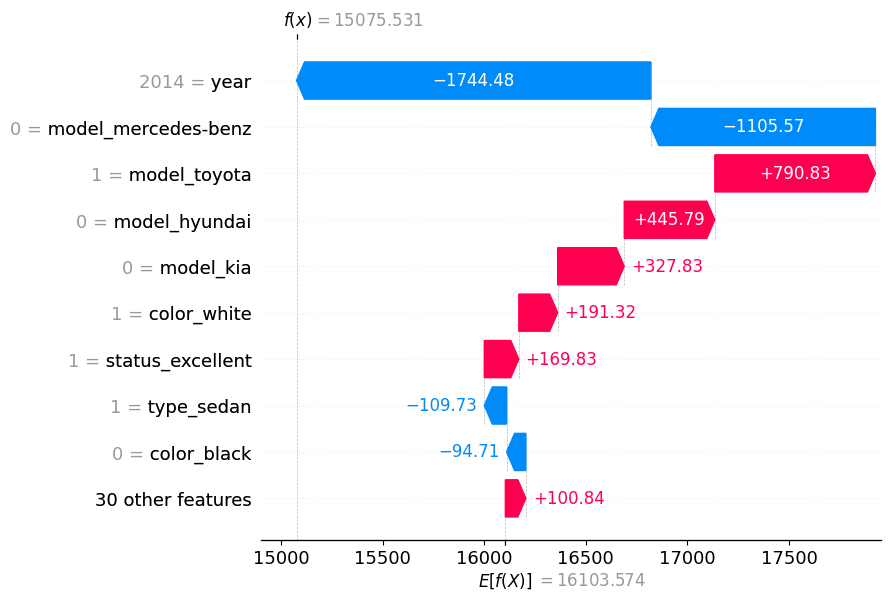

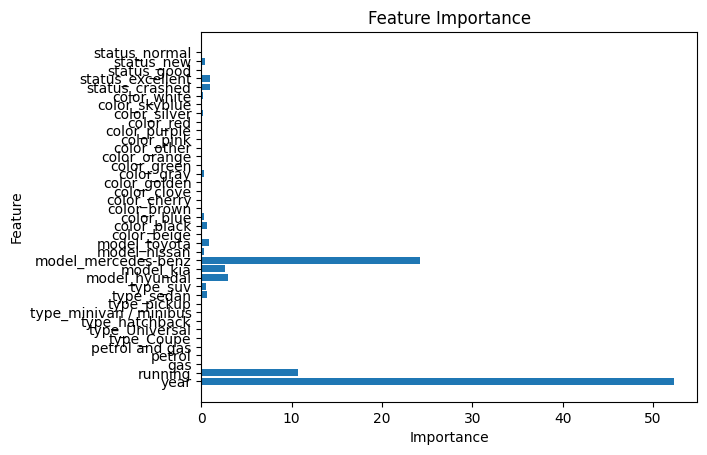

In [14]:
one_hot_org_data# shap 시각화
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_train)

# SHAP summary plot 출력
print('summary plot')
shap.summary_plot(shap_values, X_train)
'''
# SHAP force plot 출력
print('force_plot')
shap.force_plot(explainer.expected_value, shap_values[0], X_train.iloc[0, :])
'''
# SHAP dependence plot 출력 (예시로 running을 기준으로)
print('dependence plot')
shap.dependence_plot('running', shap_values, X_train)

# SHAP waterfall plot 출력
print('waterfall plot')
shap.waterfall_plot(shap.Explanation(values = shap_values[0], base_values = explainer.expected_value, data=X_train.iloc[0, :]))

#피쳐 중요도
feature_importances = model.get_feature_importance()
feature_names = X_train.columns

plt.barh(feature_names, feature_importances)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

In [16]:
one_hot_org_data.columns

Index(['year', 'running', 'price', 'gas', 'petrol', 'petrol and gas',
       'type_Coupe', 'type_Universal', 'type_hatchback',
       'type_minivan / minibus', 'type_pickup', 'type_sedan', 'type_suv',
       'model_hyundai', 'model_kia', 'model_mercedes-benz', 'model_nissan',
       'model_toyota', 'color_beige', 'color_black', 'color_blue',
       'color_brown', 'color_cherry', 'color_clove', 'color_golden',
       'color_gray', 'color_green', 'color_orange', 'color_other',
       'color_pink', 'color_purple', 'color_red', 'color_silver',
       'color_skyblue', 'color_white', 'status_crashed', 'status_excellent',
       'status_good', 'status_new', 'status_normal'],
      dtype='object')

In [17]:
one_hot_org_data_color_drop = one_hot_org_data.drop(['color_beige', 'color_black', 'color_blue',
       'color_brown', 'color_cherry', 'color_clove', 'color_golden',
       'color_gray', 'color_green', 'color_orange', 'color_other',
       'color_pink', 'color_purple', 'color_red', 'color_silver',
       'color_skyblue', 'color_white'], axis=1)

In [19]:
one_hot_org_data_color_drop.columns

Index(['year', 'running', 'price', 'gas', 'petrol', 'petrol and gas',
       'type_Coupe', 'type_Universal', 'type_hatchback',
       'type_minivan / minibus', 'type_pickup', 'type_sedan', 'type_suv',
       'model_hyundai', 'model_kia', 'model_mercedes-benz', 'model_nissan',
       'model_toyota', 'status_crashed', 'status_excellent', 'status_good',
       'status_new', 'status_normal'],
      dtype='object')

In [20]:
#전체데이터 다넣어서 해봄

def catboost_cv_total(learning_rate, depth, l2_leaf_reg):
    # CatBoost 모델 정의
    model = CatBoostRegressor(
        iterations = 1000,
        learning_rate = learning_rate,
        depth = int(depth),
        l2_leaf_reg = l2_leaf_reg,
        verbose = 0
    )
    
    # 모델 학습
    model.fit(X_train, y_train)
    
    # 검증 데이터에 대한 예측
    y_pred = model.predict(X_test)
    
    # mae 에러
    mae = mean_absolute_error(y_test, y_pred)
    
    # 최소화할 목적 함수 반환
    return -mae


total_train = deepcopy(org_data_train)

x = one_hot_org_data_color_drop.drop('price', axis = 1)
y = one_hot_org_data_color_drop['price']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

#베이지안 최적화
optimizer = BayesianOptimization(
f = catboost_cv_total,
pbounds = pbounds,
random_state = 42,
)

optimizer.maximize(init_points = 5, n_iter = 10)
print(optimizer.max)


|   iter    |  target   |   depth   | l2_lea... | learni... |
-------------------------------------------------------------
| 1         | -2.088e+0 | 5.622     | 9.556     | 0.2223    |
| 2         | -2.09e+03 | 7.191     | 2.404     | 0.05524   |
| 3         | -2.007e+0 | 3.407     | 8.796     | 0.1843    |
| 4         | -2.354e+0 | 7.957     | 1.185     | 0.2913    |
| 5         | -2.101e+0 | 8.827     | 2.911     | 0.06273   |
| 6         | -1.997e+0 | 3.342     | 8.864     | 0.2441    |
| 7         | -1.956e+0 | 3.0       | 10.0      | 0.01      |
| 8         | -1.929e+0 | 6.431     | 4.388     | 0.01      |
| 9         | -1.929e+0 | 4.648     | 3.731     | 0.01      |
| 10        | -2.076e+0 | 3.044     | 5.245     | 0.2701    |
| 11        | -1.932e+0 | 3.534     | 1.86      | 0.01      |
| 12        | -1.959e+0 | 8.387     | 6.035     | 0.01      |
| 13        | -2.214e+0 | 10.0      | 8.26      | 0.3       |
| 14        | -2.226e+0 | 6.349     | 6.241     | 0.3       |
| 15    

In [21]:
# 전체 데이터 모델 학습
'''
model = CatBoostRegressor(iterations = 1000, 
                              learning_rate = 0.035, 
                              depth = 4, 
                              l2_leaf_reg = 4.591, 
                              verbose = 0)
'''
model = CatBoostRegressor(iterations = 1000, 
                              learning_rate = optimizer.max['params']['learning_rate'], 
                              depth = int(round(optimizer.max['params']['depth'], 0)), 
                              l2_leaf_reg = optimizer.max['params']['l2_leaf_reg'], 
                              verbose = 0)

model.fit(X_train, y_train)

# 모델 평가
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print()
print(f"Mean Absolute Error (MAE): {mae}")
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')
print()


Mean Absolute Error (MAE): 1925.3392534503407
Mean Squared Error: 10134848.312487572
R^2 Score: 0.7896175357858862



summary plot


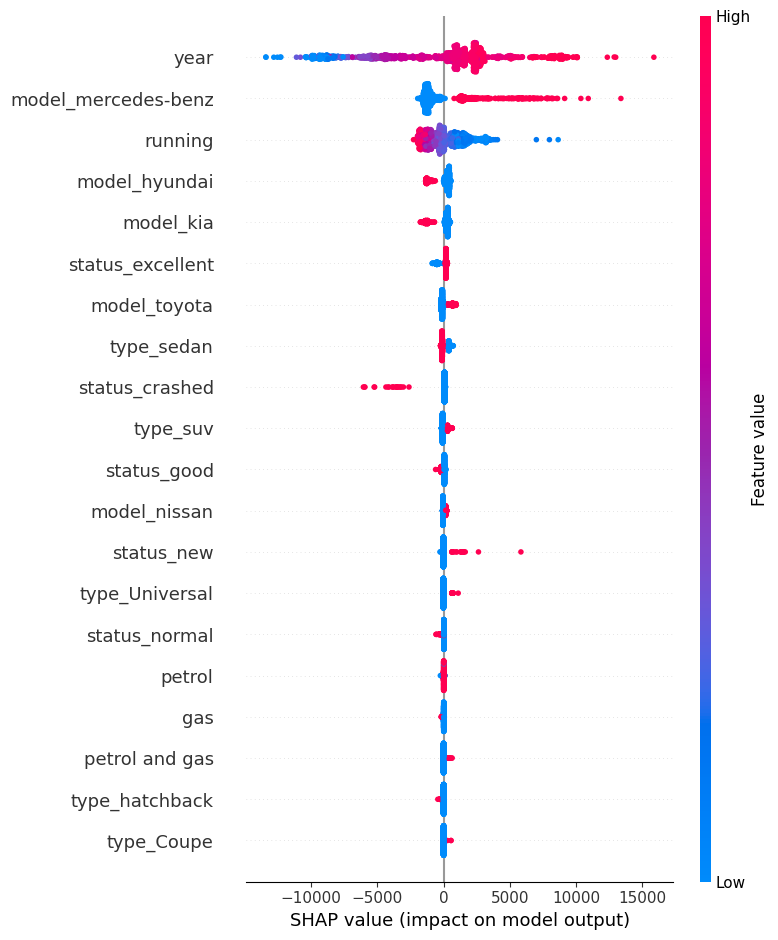

dependence plot


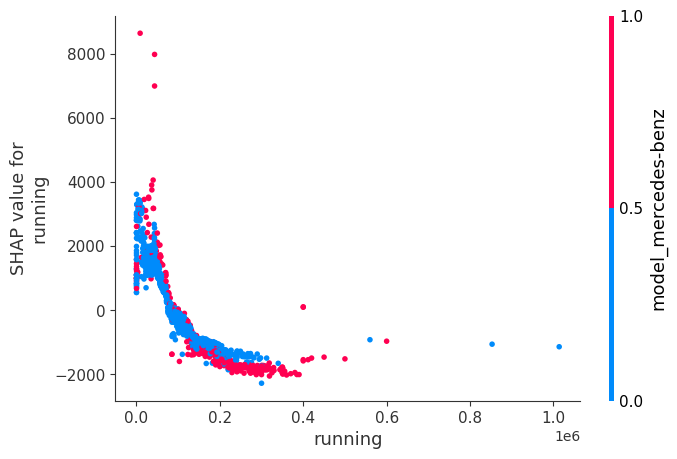

waterfall plot


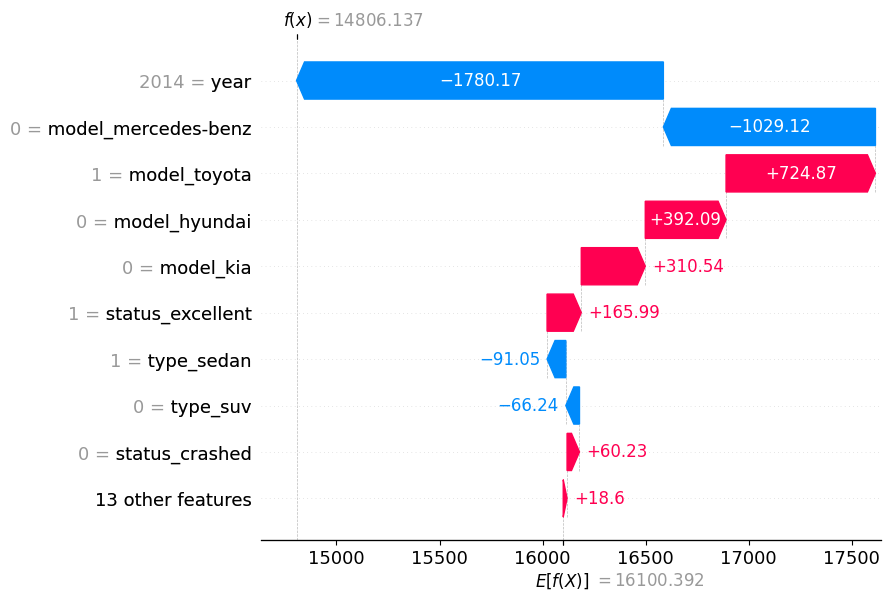

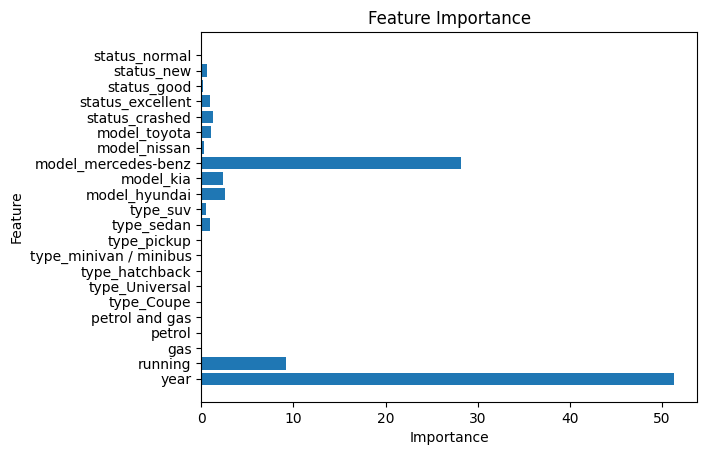

In [22]:
one_hot_org_data# shap 시각화
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_train)

# SHAP summary plot 출력
print('summary plot')
shap.summary_plot(shap_values, X_train)
'''
# SHAP force plot 출력
print('force_plot')
shap.force_plot(explainer.expected_value, shap_values[0], X_train.iloc[0, :])
'''
# SHAP dependence plot 출력 (예시로 running을 기준으로)
print('dependence plot')
shap.dependence_plot('running', shap_values, X_train)

# SHAP waterfall plot 출력
print('waterfall plot')
shap.waterfall_plot(shap.Explanation(values = shap_values[0], base_values = explainer.expected_value, data=X_train.iloc[0, :]))

#피쳐 중요도
feature_importances = model.get_feature_importance()
feature_names = X_train.columns

plt.barh(feature_names, feature_importances)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

In [24]:
one_hot_org_data_color_drop.columns

Index(['year', 'running', 'price', 'gas', 'petrol', 'petrol and gas',
       'type_Coupe', 'type_Universal', 'type_hatchback',
       'type_minivan / minibus', 'type_pickup', 'type_sedan', 'type_suv',
       'model_hyundai', 'model_kia', 'model_mercedes-benz', 'model_nissan',
       'model_toyota', 'status_crashed', 'status_excellent', 'status_good',
       'status_new', 'status_normal'],
      dtype='object')

In [25]:
one_hot_org_data_color_gas_drop = one_hot_org_data_color_drop.drop(['gas','petrol','petrol and gas'], axis=1)

In [26]:
#전체데이터 다넣어서 해봄

def catboost_cv_total(learning_rate, depth, l2_leaf_reg):
    # CatBoost 모델 정의
    model = CatBoostRegressor(
        iterations = 1000,
        learning_rate = learning_rate,
        depth = int(depth),
        l2_leaf_reg = l2_leaf_reg,
        verbose = 0
    )
    
    # 모델 학습
    model.fit(X_train, y_train)
    
    # 검증 데이터에 대한 예측
    y_pred = model.predict(X_test)
    
    # mae 에러
    mae = mean_absolute_error(y_test, y_pred)
    
    # 최소화할 목적 함수 반환
    return -mae


total_train = deepcopy(org_data_train)

x = one_hot_org_data_color_gas_drop.drop('price', axis = 1)
y = one_hot_org_data_color_gas_drop['price']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

#베이지안 최적화
optimizer = BayesianOptimization(
f = catboost_cv_total,
pbounds = pbounds,
random_state = 42,
)

optimizer.maximize(init_points = 5, n_iter = 10)
print(optimizer.max)


|   iter    |  target   |   depth   | l2_lea... | learni... |
-------------------------------------------------------------
| 1         | -2.11e+03 | 5.622     | 9.556     | 0.2223    |
| 2         | -2.092e+0 | 7.191     | 2.404     | 0.05524   |
| 3         | -1.986e+0 | 3.407     | 8.796     | 0.1843    |
| 4         | -2.371e+0 | 7.957     | 1.185     | 0.2913    |
| 5         | -2.104e+0 | 8.827     | 2.911     | 0.06273   |
| 6         | -2.02e+03 | 3.342     | 8.864     | 0.2441    |
| 7         | -1.947e+0 | 3.837     | 8.35      | 0.01      |
| 8         | -1.95e+03 | 3.083     | 7.885     | 0.01      |
| 9         | -2.048e+0 | 3.759     | 6.972     | 0.3       |
| 10        | -1.929e+0 | 5.869     | 3.955     | 0.01      |
| 11        | -1.925e+0 | 4.893     | 3.589     | 0.01      |
| 12        | -2.24e+03 | 5.01      | 4.698     | 0.3       |
| 13        | -1.924e+0 | 5.593     | 3.123     | 0.01      |
| 14        | -2.005e+0 | 4.448     | 2.725     | 0.09021   |
| 15    

In [29]:
# 전체 데이터 모델 학습
'''
model = CatBoostRegressor(iterations = 1000, 
                              learning_rate = 0.035, 
                              depth = 4, 
                              l2_leaf_reg = 4.591, 
                              verbose = 0)
'''
model = CatBoostRegressor(iterations = 1000, 
                              learning_rate = optimizer.max['params']['learning_rate'], 
                              depth = int(round(optimizer.max['params']['depth'], 0)), 
                              l2_leaf_reg = optimizer.max['params']['l2_leaf_reg'], 
                              verbose = 0)

model.fit(X_train, y_train)

# 모델 평가
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print()
print(f"Mean Absolute Error (MAE): {mae}")
print(f'Mean Squared Error: {math.sqrt(mse)}')
print(f'R^2 Score: {r2}')
print()


Mean Absolute Error (MAE): 1918.020055804787
Mean Squared Error: 3232.3275762948515
R^2 Score: 0.7831182447250149



summary plot


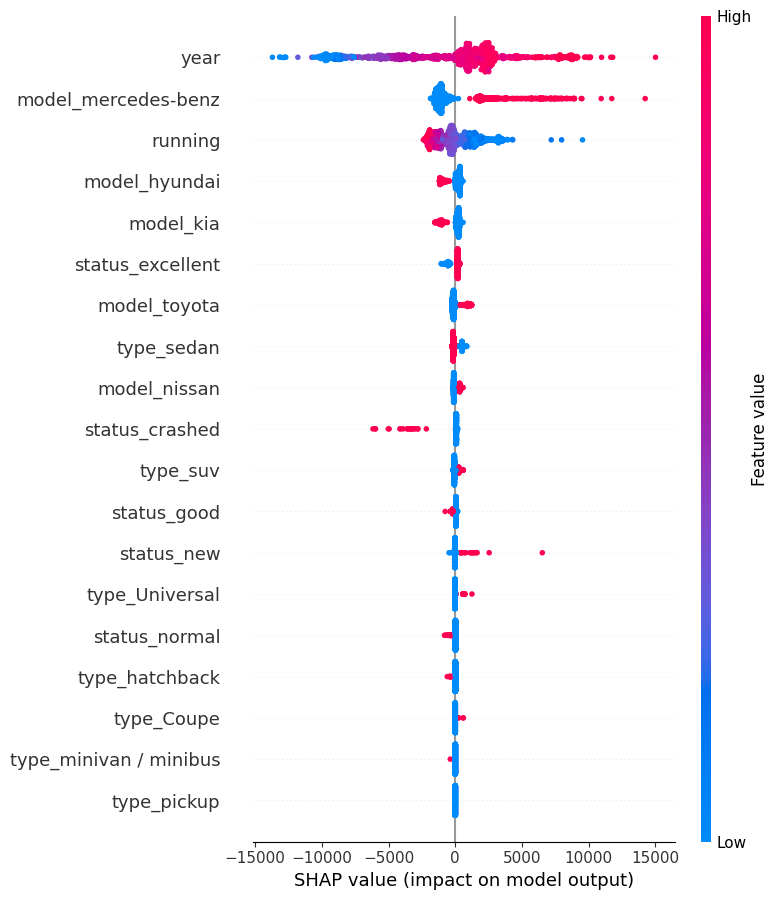

dependence plot


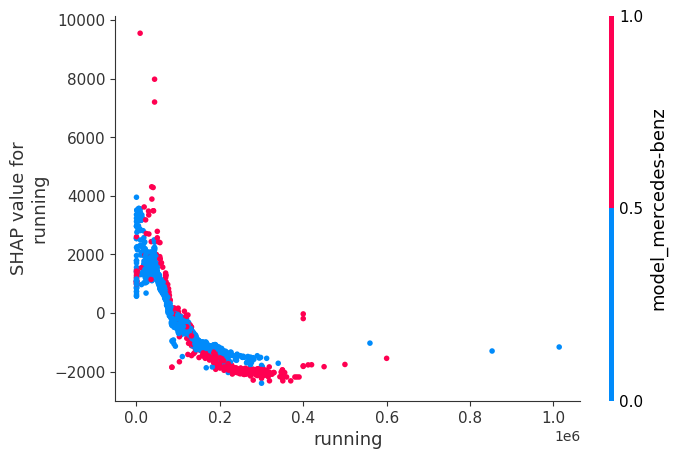

waterfall plot


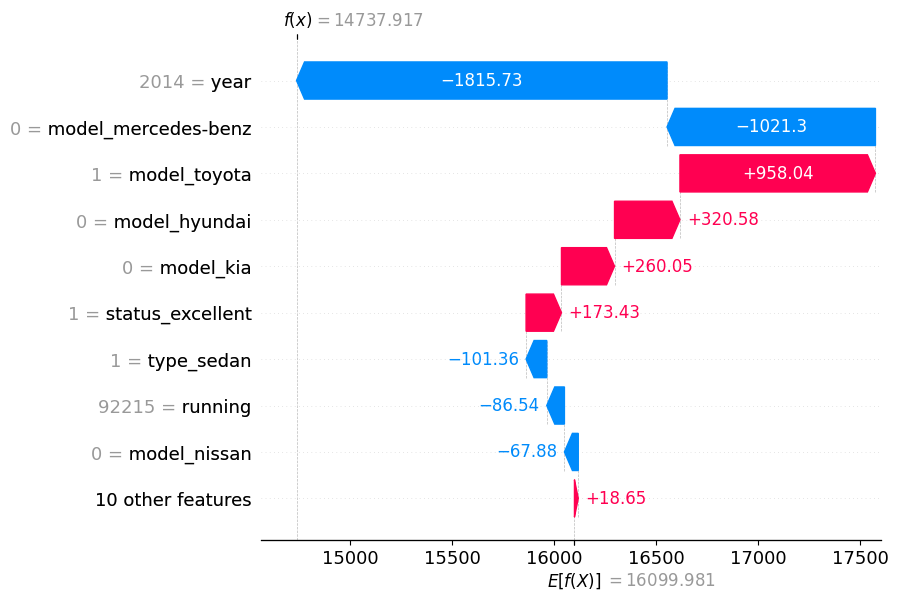

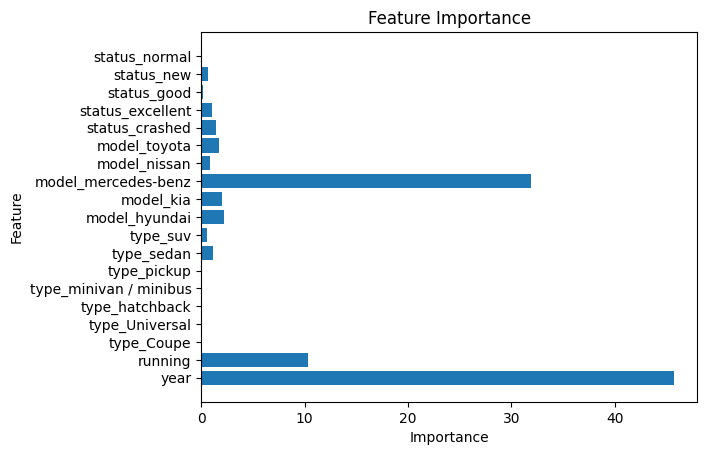

In [28]:
one_hot_org_data# shap 시각화
explainer = shap.Explainer(model)
shap_values = explainer.shap_values(X_train)

# SHAP summary plot 출력
print('summary plot')
shap.summary_plot(shap_values, X_train)
'''
# SHAP force plot 출력
print('force_plot')
shap.force_plot(explainer.expected_value, shap_values[0], X_train.iloc[0, :])
'''
# SHAP dependence plot 출력 (예시로 running을 기준으로)
print('dependence plot')
shap.dependence_plot('running', shap_values, X_train)

# SHAP waterfall plot 출력
print('waterfall plot')
shap.waterfall_plot(shap.Explanation(values = shap_values[0], base_values = explainer.expected_value, data=X_train.iloc[0, :]))

#피쳐 중요도
feature_importances = model.get_feature_importance()
feature_names = X_train.columns

plt.barh(feature_names, feature_importances)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

In [31]:
one_hot_org_data_color_gas_drop.columns

Index(['year', 'running', 'price', 'type_Coupe', 'type_Universal',
       'type_hatchback', 'type_minivan / minibus', 'type_pickup', 'type_sedan',
       'type_suv', 'model_hyundai', 'model_kia', 'model_mercedes-benz',
       'model_nissan', 'model_toyota', 'status_crashed', 'status_excellent',
       'status_good', 'status_new', 'status_normal'],
      dtype='object')

In [32]:
one_hot_org_data_color_gas_type_drop = one_hot_org_data_color_gas_drop.drop(['type_Coupe', 'type_Universal',
       'type_hatchback', 'type_minivan / minibus', 'type_pickup', 'type_sedan',
       'type_suv'], axis=1)

In [34]:
#전체데이터 다넣어서 해봄

def catboost_cv_total(learning_rate, depth, l2_leaf_reg):
    # CatBoost 모델 정의
    model = CatBoostRegressor(
        iterations = 1000,
        learning_rate = learning_rate,
        depth = int(depth),
        l2_leaf_reg = l2_leaf_reg,
        verbose = 0
    )
    
    # 모델 학습
    model.fit(X_train, y_train)
    
    # 검증 데이터에 대한 예측
    y_pred = model.predict(X_test)
    
    # mae 에러
    mae = mean_absolute_error(y_test, y_pred)
    
    # 최소화할 목적 함수 반환
    return -mae


total_train = deepcopy(org_data_train)

x = one_hot_org_data_color_gas_type_drop.drop('price', axis = 1)
y = one_hot_org_data_color_gas_type_drop['price']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

#베이지안 최적화
optimizer = BayesianOptimization(
f = catboost_cv_total,
pbounds = pbounds,
random_state = 42,
)

optimizer.maximize(init_points = 5, n_iter = 10)
print(optimizer.max)

|   iter    |  target   |   depth   | l2_lea... | learni... |
-------------------------------------------------------------
| 1         | -2.131e+0 | 5.622     | 9.556     | 0.2223    |
| 2         | -2.11e+03 | 7.191     | 2.404     | 0.05524   |
| 3         | -2.027e+0 | 3.407     | 8.796     | 0.1843    |
| 4         | -2.329e+0 | 7.957     | 1.185     | 0.2913    |
| 5         | -2.119e+0 | 8.827     | 2.911     | 0.06273   |
| 6         | -2.048e+0 | 3.342     | 8.864     | 0.2441    |
| 7         | -1.95e+03 | 3.824     | 8.184     | 0.01      |
| 8         | -1.952e+0 | 3.055     | 7.381     | 0.01      |
| 9         | -1.925e+0 | 4.225     | 6.527     | 0.01      |
| 10        | -1.944e+0 | 3.116     | 5.353     | 0.01      |
| 11        | -1.931e+0 | 5.008     | 4.733     | 0.01      |
| 12        | -2.113e+0 | 3.687     | 3.141     | 0.3       |
| 13        | -1.931e+0 | 6.239     | 5.896     | 0.01      |
| 14        | -1.953e+0 | 8.436     | 6.215     | 0.01      |
| 15    

In [35]:
# 전체 데이터 모델 학습
'''
model = CatBoostRegressor(iterations = 1000, 
                              learning_rate = 0.035, 
                              depth = 4, 
                              l2_leaf_reg = 4.591, 
                              verbose = 0)
'''
model = CatBoostRegressor(iterations = 1000, 
                              learning_rate = optimizer.max['params']['learning_rate'], 
                              depth = int(round(optimizer.max['params']['depth'], 0)), 
                              l2_leaf_reg = optimizer.max['params']['l2_leaf_reg'], 
                              verbose = 0)

model.fit(X_train, y_train)

# 모델 평가
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print()
print(f"Mean Absolute Error (MAE): {mae}")
print(f'Mean Squared Error: {math.sqrt(mse)}')
print(f'R^2 Score: {r2}')
print()


Mean Absolute Error (MAE): 1925.253166399304
Mean Squared Error: 3145.471653856592
R^2 Score: 0.794617310692592

